In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot

sns.set()


In [ ]:
dick = pd.read_pickle('country_data.pkl')
world_df = pd.read_pickle('global_data.pkl')

swe = dick['Sweden']
swe


In [ ]:
# fix erroneous data
esp = dick['Spain']
print (esp.loc['2020-04-24'])
esp.at['2020-04-24','inc'] = 1 # poisson cant deal with negative numbers
dick['Spain'] = esp

In [ ]:
US = pd.read_pickle('us_state_dict.pkl')
ny = US['New York']
ny = ny[['confirmed','deceased','inc','factor','dead_inc','dead_factor','pct_dead']]
dick['New York'] = ny
ny

In [ ]:
M_mu_s = pm.rbeta(alpha=2,beta=100,size=100000)
_ = plt.hist(M_mu_s)

In [ ]:
F_mu_mu = pm.runiform (1,5,size=1000000)
F_mu_sigma = pm.runiform(0.1,0.9, size=1000000)
F_mu_s = pm.rlognormal(F_mu_mu,1/F_mu_sigma**2, size=1000000)
_ = plt.hist(F_mu_s,bins=50)

print(F_mu_s.min())
print (F_mu_s.max())
print (np.percentile(F_mu_s,[25,50,75]))

In [ ]:
M_ = pm.rbeta(5,500,size=1000000)
_ = plt.hist(M_,bins=50)

In [ ]:


def process_country(country,C,D):
    df = dick[country]
    
    mask = df['confirmed'] > 500
    df = df[mask]
    mask = df['deceased'] > 5
    df = df[mask]
    mask = df['dead_inc'] > 1 # or it crashes when doing inc  & dead_inc
    df = df[mask]
    
    df = df.iloc[-30:]
    
    print ('++++++++ {} ++++++++++'.format(country))
    print ()
    print (df.tail(40))
    print()
    
    if df.size < 1 :
        print ('Not enough data - DataFrame empty! ')
    else:
        confirmed_mean = df['confirmed'].mean()
        confirmed_std = df['confirmed'].std()
        dead_mean = df['deceased'].mean()
        dead_std = df['deceased'].std()

        #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
        #dead_s = (df['deceased'] - dead_mean) / dead_std

        confirmed_s = df[C]
        dead_s = df[D]

        #plt.plot(confirmed_s,dead_s,'x--')

        #M_mu = pm.Uniform('M_mu',lower=0.1,upper=1)

        F_mu = pm.Uniform('F_mu',lower=1.1,upper=5)
        F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.9)

        M_alpha = pm.Uniform('M_alpha',lower=1,upper=10)
        M_beta = pm.Uniform ('M_beta',lower=500,upper=1000)


        M = pm.Beta('M',alpha=M_alpha,beta=M_beta)
        F = pm.Lognormal('F',mu=F_mu, tau=1 / F_sigma ** 2) 


        @pm.deterministic()
        def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
            return confirmed_s * F * M

        obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)
            
                
        model = pm.Model([M_alpha,M_beta,F_mu,F_sigma,M,F,gen_dead,obs])
        map_ = pm.MAP(model)
        
        try:
            map_.fit(method='fmin_powell')
        except:
            print ('couldnt fit {}'.format(country))

        mcmc = pm.MCMC(model)
        mcmc.sample(5000000,3000000,19)

        M_alpha_post = mcmc.trace('M_alpha')[:]
        M_beta_post = mcmc.trace('M_beta')[:]
        F_mu_post = mcmc.trace('F_mu')[:]
        F_sigma_post = mcmc.trace('F_sigma')[:]
        M_post = mcmc.trace('M')[:]
        F_post = mcmc.trace('F')[:]
        gen_dead_post = mcmc.trace('gen_dead')[:,0]
        
        #pmplot (M_alpha_post,'M_alpha_post')
        #pmplot(M_beta_post,'M_beta_post')
        #pmplot(F_mu_post,'F_mu_post')
        #pmplot(F_sigma_post,'F_sigma_post')
        pmplot(M_post,'M_post')
        pmplot(F_post,'F_post')
        

        result = pd.DataFrame({'M_alpha_post' : M_alpha_post,
                                   'M_beta_post' : M_beta_post,
                                   'F_mu_post' : F_mu_post,
                                   'F_sigma_post' : F_sigma_post,
                                   'M_post' : M_post,
                                   'F_post' : F_post,
                              'gen_dead_post' : gen_dead_post})
        

        return result
    return None

def plot(country_name,result,official_mortality,official_confirmed):
    
    M_low,M_high = np.percentile(result.M_post,[5.5,94.5])
    F_low,F_high = np.percentile(result.F_post,[5.5,94.5])
    
    hpdi_M = pm.utils.hpd(result.M_post, alpha=0.50)
    hpdi_F = pm.utils.hpd(result.F_post,alpha=0.50)
    
    print (hpdi_M,hpdi_F)
    
    low_conf_estimate = hpdi_F[0] * official_confirmed
    high_conf_estimate = hpdi_F[1] * official_confirmed
    
    plt.figure(figsize=(18,12))
    plt.subplot(411)
    plt.title('Bayesian estimation of Mortality rate for {} , official mortality {:.2f}\n official confirmed {:.0f} Expected confirmed with 50% HPDI range {:.0f} - {:.0f}'.format(
        country_name,official_mortality / 100,official_confirmed, low_conf_estimate,high_conf_estimate))
    
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(M_low))
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(M_high))
    plt.axvline(result.M_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.M_post.mean()))
    plt.axvline(result.M_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.M_post.median()))

    plt.axvline(hpdi_M[0],color='k',label='HPDI-50% low at {:.3f}'.format(hpdi_M[0]),ls='dashed')
    plt.axvline(hpdi_M[1],color='k',ls='dashed',label='HPDI-50% high at {:.3f}'.format(hpdi_M[1]))
    
    hist = plt.hist(result.M_post,density=True,bins=10,alpha=0.7,color='b',histtype='stepfilled')
    #plt.fill_between(x=hpdi_M,y1=0,y2=max(hist[0]),color='r',alpha=0.7,label='HPDI-50%')
    plt.legend(loc='upper right')


    plt.subplot(413)
    plt.title('Bayesian estimation of "Off-By-Factor for Confirmed" rate for {}'.format(country_name))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(F_low))
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(F_high))
    plt.axvline(result.F_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.F_post.mean()))
    plt.axvline(result.F_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.F_post.median()))

    plt.axvline(hpdi_F[0],color='k',label='HPDI-50% low at {:.3f}'.format(hpdi_F[0]),ls='dashed')
    plt.axvline(hpdi_F[1],color='k',ls='dashed',label='HPDI-50% high at {:.3f}'.format(hpdi_F[1]))
    
    hist = plt.hist(result.F_post,density=True,bins=10,alpha=0.7,color='b',histtype='stepfilled')
    #plt.fill_between(x=hpdi_F,y1=0,y2=max(hist[0]),color='r',alpha=0.7,label='HPDI-50%')

    plt.legend(loc='upper right')
    
    plt.subplot(412)
    
    plt.title('Cumulative Probability True  Mortality Rate for {}'.format(c))
    M_samples = result.M_post 
    M_samples = np.sort(M_samples)
    M_dist = M_samples / M_samples.sum()
    plt.plot(M_samples,M_dist.cumsum())
    plt.ylabel('Probability')
    plt.xlabel('Mortality Rate')
    
    plt.subplot(414)
    
    plt.title('Cumulative Probability True  Factor Confirmed for {}'.format(c))
    F_samples = result.F_post 
    F_samples = np.sort(F_samples)
    F_dist = F_samples / F_samples.sum()
    plt.plot(F_samples,F_dist.cumsum())
    plt.ylabel('Probability')
    plt.xlabel('Factor Confirmed')
    
    plt.tight_layout()

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}_.jpg'.format(country_name),format='jpg')

countries = ['US','Sweden','India','Germany','Spain','Italy','New York']
#countries = ['Spain','Italy','New York']
#countries = ['Sweden']

for c in countries:
    
    result = process_country(c,'inc','dead_inc')
    if not (result is None) :
        
        official_mortality = dick[c].iloc[-1,6]
        official_confirmed = dick[c]['confirmed'][-1]

        plot(c,result,official_mortality,official_confirmed)
        print ()
        print (result.describe())
       

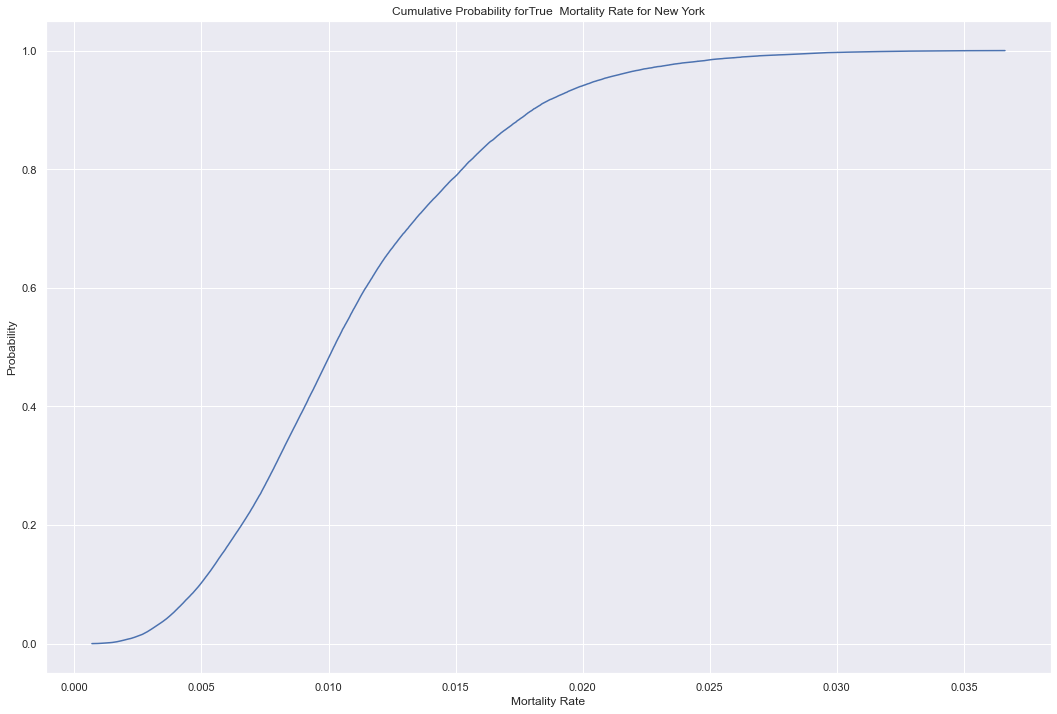

In [45]:
plt.figure(figsize=(18,12))
plt.title('Cumulative Probability forTrue  Mortality Rate for {}'.format(c))
M_samples = result.M_post 
M_samples = np.sort(M_samples)
M_dist = M_samples / M_samples.sum()
plt.plot(M_samples,M_dist.cumsum())
plt.ylabel('Probability')
plt.xlabel('Mortality Rate')
plt.savefig('Cumulative_Mortality_Rate_{}.jpg',format='jpg')

In [ ]:
def process_world(df,C,D):
    
    mask = df['confirmed'] > 1000
    df = df[mask]
    mask = df['dead'] > 5
    df = df[mask]
    
    df = df.iloc[-30:]
    
    confirmed_mean = df['confirmed'].mean()
    confirmed_std = df['confirmed'].std()
    dead_mean = df['dead'].mean()
    dead_std = df['dead'].std()
    
    #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
    #dead_s = (df['deceased'] - dead_mean) / dead_std
    
    confirmed_s = df[C]
    dead_s = df[D]
    
    plt.plot(confirmed_s,dead_s,'x--')
    
    #F_mu = pm.Uniform('F_mu',lower=1,upper=1.2)
    #F_sigma = pm.Uniform('F_sigma',lower=0.19,upper=0.21)
    
    #F_mu = pm.Uniform('F_mu',lower=1.1,upper=2)
    #F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.3)
    
    F_mu = pm.Uniform('F_mu',lower=1.1,upper=3)
    F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.9)
    
    #M_alpha = pm.Uniform('M_alpha',lower=1,upper=1000)
    #M_beta = pm.Uniform ('M_beta',lower=1,upper=1000)
    
    M_alpha = pm.Uniform('M_alpha',lower=1,upper=10)
    M_beta = pm.Uniform ('M_beta',lower=500,upper=1000)
    
    M = pm.Beta('M',alpha=M_alpha,beta=M_beta)
    F = pm.Lognormal('F',mu=F_mu, tau=1 / F_sigma ** 2) #0.6 0.2
    
    
    @pm.deterministic()
    def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
        return confirmed_s * F * M
    
    obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)
    
    model = pm.Model([M_alpha,M_beta,F_mu,F_sigma,M,F,gen_dead,obs])
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(5000000,3000000,9)
    
    M_alpha_post = mcmc.trace('M_alpha')[:]
    M_beta_post = mcmc.trace('M_beta')[:]
    F_mu_post = mcmc.trace('F_mu')[:]
    F_sigma_post = mcmc.trace('F_sigma')[:]
    M_post = mcmc.trace('M')[:]
    F_post = mcmc.trace('F')[:]
    gen_dead_post = mcmc.trace('gen_dead')[:,0]
    
    #pmplot (M_alpha_post,'M_alpha_post')
    #pmplot(M_beta_post,'M_beta_post')
    #pmplot(F_mu_post,'F_mu_post')
    #pmplot(F_sigma_post,'F_sigma_post')
    pmplot(M_post,'M_post')
    pmplot(F_post,'F_post')
    
    result = pd.DataFrame({'M_alpha_post' : M_alpha_post,
                          'M_beta_post' : M_beta_post,
                          'F_mu_post' : F_mu_post,
                          'F_sigma_post' : F_sigma_post,
                          'M_post' : M_post,
                          'F_post' : F_post,
                          'gen_dead_post' : gen_dead_post})
    
    return result

def plot_world(result,title,official_mortality):
    
    M_low,M_high = np.percentile(result.M_post,[5.5,94.5])
    F_low,F_high = np.percentile(result.F_post,[5.5,94.5])
    
    hpdi_M = pm.utils.hpd(result.M_post, alpha=0.50)
    hpdi_F = pm.utils.hpd(result.F_post,alpha=0.50)
    
    
    plt.figure(figsize=(18,12))
    plt.subplot(211)
    plt.title('Bayesian estimation of Mortality rate for {}, official mortality {:.2f}'.format(title,official_mortality))
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(M_low))
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(M_high))
    plt.axvline(result.M_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.M_post.mean()))
    plt.axvline(result.M_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.M_post.median()))

    
    plt.axvline(hpdi_M[0],color='k',label='HPDI-50% low at {:.3f}'.format(hpdi_M[0]),ls='dashed')
    plt.axvline(hpdi_M[1],color='k',ls='dashed',label='HPDI-50% high at {:.3f}'.format(hpdi_M[1]))
    
    hist = plt.hist(result.M_post,density=True,bins=10,alpha=0.7,color='b')

    plt.legend(loc='upper right')
    plt.hist(result.M_post,density=True,bins=10)

    plt.subplot(212)
    plt.title('Bayesian estimation of "Off-By-Factor for Confirmed" rate for {}'.format(title))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(F_low))
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(F_high))
    plt.axvline(result.F_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.F_post.mean()))
    plt.axvline(result.F_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.F_post.median()))

    
    plt.axvline(hpdi_F[0],color='k',label='HPDI-50% low at {:.3f}'.format(hpdi_F[0]),ls='dashed')
    plt.axvline(hpdi_F[1],color='k',ls='dashed',label='HPDI-50% high at {:.3f}'.format(hpdi_F[1]))
    
    hist = plt.hist(result.F_post,density=True,bins=10,alpha=0.7,color='b')

    plt.legend(loc='upper right')

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}.jpg'.format(title),format='jpg')

world_df = pd.read_pickle('global_data.pkl')

#result_world = process_world(world_df,'inc','dead_inc')
official_mortality = world_df.iloc[-1,6]
plot_world(result_world,'Global',official_mortality)
